# Connecticut Library Trends Analysis

### A collaborative analysis of library usage and funding trends across Connecticut counties over multiple fiscal years.

# Background

The dataset we used on public library usage is sourced from Connecticut's Open Data portal:
[https://data.ct.gov/Education/Public-Libraries/kf75-36tt/about_data]

Statistical background for the Fiscal Year 2023
[https://libguides.ctstatelibrary.org/ld.php?content_id=72332656]

Broad searches for public library datasets led us to Connecticut's dataset, organized by fiscal year, then library branch, containing data on internal library statistics (e.g. library visits, circulation counts, program counts) as well as external information surrounding that branch (e.g. population of service area, tax appropriation per library, Adjusted Equalized Net Grand List per Capita).

In [2]:
#Libraries utilized
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import linregress

import ipywidgets as widgets
from ipywidgets import interact, interactive

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from IPython import display

In [3]:
# Read in data
cld = pd.read_csv("library_data/COUNTY_connecticut_library_data.csv")

# Create a melted dataframe with library branches as the index
cldMelt = pd.melt(cld, id_vars="Library")
cldMelt.describe()

# Create a melted dataframe with counties as the index
countyMelt = pd.melt(cld, id_vars="County")

cld.head()

,Fiscal Year,Library,County,Principal Public?,AENGLC Rank,Population of Service Area,Total Library Visits,Library Visits Per Capita Served,Total Registered Borrowers,Percent of Residents with Library Cards,...,Total Collection,Collection Per Capita Served,Total Operating Income,Operating Income Per Capita,Town Tax Appropriation for Library,Tax Appropriation Per Capita Served,Library Materials Expenditures,Wages & Salaries Expenditures,Operating Expenditures,Operating Expenditures Per Capita
0,1996,Andover,Tolland,P,109.0,2815.0,15000.0,5.3,1313.0,0.47,...,15285.0,5.4,56300.0,20.00,52915.0,18.80,10073.0,30996.0,44290.0,15.7
1,1996,Ansonia,New Haven,P,158.0,17825.0,91756.0,5.1,6952.0,0.39,...,63685.0,3.6,320679.0,17.99,323503.0,18.15,45874.0,201621.0,270658.0,15.2
2,1996,Ashford-Babcock,Windham,P,131.0,3969.0,8665.0,2.2,1360.0,0.34,...,23818.0,6.0,111699.0,28.14,106713.0,26.89,11508.0,62295.0,82769.0,20.9
3,1996,Avon,Hartford,P,19.0,14143.0,162893.0,11.5,8808.0,0.62,...,74903.0,5.3,685678.0,48.48,602831.0,42.62,92711.0,340400.0,516583.0,36.5
4,1996,Beacon Falls,New Haven,P,129.0,5351.0,7000.0,1.3,1379.0,0.26,...,10042.0,1.9,40806.0,7.63,39256.0,7.34,4298.0,21585.0,39165.0,7.3


# Analysis:

According to the Connecticut State Library's report for the fiscal year 2023, they cite the following as "lows" of the year as decreases from FY2022's stats (Ghilardi, 2024):
* The decrease in percent of CT residents with library cards
* Lower total circulation
* Lower operating income per capita, due to federal grants ending

The counties Windham and Litchfield have the lowest average "Population of Service Area" and are classified as rural according to the Connecticut State Office of Rural Health (n.d). 

While these statistics are true for the fiscal year of 2023, what does the overall relationship look like between either total circulation or operating income per capita, and the percent of residents with library cards for these rural counties?

[organized by County, explore a County's growth over the fiscal years between (explanatory variable) and percent of residents with library cards]

In [4]:
# Group by Population of Service Area
cld[['County','Population of Service Area']].groupby(by="County").mean().sort_values(by="Population of Service Area")

,Population of Service Area
County,
Windham,7661.992891
Litchfield,7676.503715
Middlesex,10715.635714
Tolland,11201.109890
New London,14860.036496
Hartford,30179.307882
New Haven,31170.783069
Fairfield,39141.727975


## Function definitions: Bivariate linear regression, by branch level, and by county level

In [5]:
def linregcombined(selectlevel, branch, county, exvar, respvar, export=False):
    
    # Select to either analyze at the branch or county level, with widget -- select the appropriate dataframe and index column
    if selectlevel == "Branch":
        locLibrary = cldMelt["Library"] == branch
        levelSelected = cldMelt[locLibrary]
        name = branch

    elif selectlevel == "County":
        locLibrary = countyMelt["County"] == county
        levelSelected = countyMelt[locLibrary]
        name = county
    
    # Create dataframes to query values from
    locVar1 = levelSelected["variable"] == exvar
    dfVar1 = levelSelected[locVar1].value
    dfVar1 = dfVar1.fillna(dfVar1.mean())

    locVar2 = levelSelected["variable"] == respvar
    dfVar2 = levelSelected[locVar2].value
    dfVar2 = dfVar2.fillna(dfVar2.mean())

    # Form linear regression model
    model = linregress(dfVar1.astype(float), dfVar2.astype(float))
    m, b = model.slope,model.intercept
    x = np.arange(dfVar1.min(),dfVar1.max()+1)
    yhat = m*x+b
    
    # Plot scatterplot
    fig, ax = plt.subplots()
    plt.subplots_adjust(right=0.7)
    ax.scatter(dfVar1,dfVar2)
    ax.plot(x,yhat)
    ax.set_xlabel(f"{exvar}")
    ax.set_ylabel(f"{respvar}")
    ax.set_title(f"[{name} {selectlevel}] Linear regression model between {exvar} and {respvar}")
    
    # Linear regression parameters text print
    fig.text(0.75,0.6,f"R Value: {round(model.rvalue,3)}")
    fig.text(0.75,0.4,f"P Value: {round(model.pvalue,10)}")

    if export == True:
        plt.savefig(fname=f"[{name} {selectlevel}] Linear regression model between {exvar} and {respvar}", bbox_inches="tight")

In [6]:
### Widgets

style = {'description_width': 'initial'}

librarySelector = widgets.Dropdown(
    options=cldMelt["Library"].unique(),
    value="Andover",
    description='Select a library:',
    disabled=False,
    style=style
)

countySelector = widgets.Dropdown(
    options=countyMelt["County"].unique(),
    value="Tolland",
    description='Select a county:',
    disabled=False,
    style=style
)

levelSelector = widgets.Dropdown(
    options=["Branch", "County"],
    value="Branch",
    description='Select level of analysis:',
    disabled=False,
    style=style
)

var1Selector = widgets.Dropdown(
    options=cldMelt["variable"].unique(),
    value="Fiscal Year",
    description='Select explanatory variable:',
    disabled=False,
    style=style
)

var2Selector = widgets.Dropdown(
    options=cldMelt["variable"].unique(),
    value="Fiscal Year",
    description='Select response variable:',
    disabled=False,
    style=style
)

exportFile = widgets.ToggleButton(
    value=False,
    description='Export Graph',
    disabled=False,
    button_style='success',
    tooltip='Description',
    icon='check' 
)

In [8]:
interactivePlot = interact(linregcombined, selectlevel = levelSelector, exvar=var1Selector, respvar=var2Selector, export=exportFile, 
                           branch = librarySelector, county = countySelector)

### Interpretation

With regards to the relationship between total circulation and percent of residents with library cards:
* Windham County demonstrates a weak positive correlation
* Litchfield County demonstrates no statistically discernable correlation

With regards to the relationship between operating income per capita and percent of residents with library cards:
* Litchfield County demonstrates a weak positive correlation
* Windham County demonstrates a moderately strong positive correlation

Intuitively, the areas of need that Ghilardi identified in the FY2023 report would be appropriate targets for a library to address: having more materials and being a profitable institution would certainly increase the appeal for people to register for a library card. While Windham County's libraries follow these trends, Litchfield County appears not to. Does Litchfield County have any anomalous features compared to other counties?

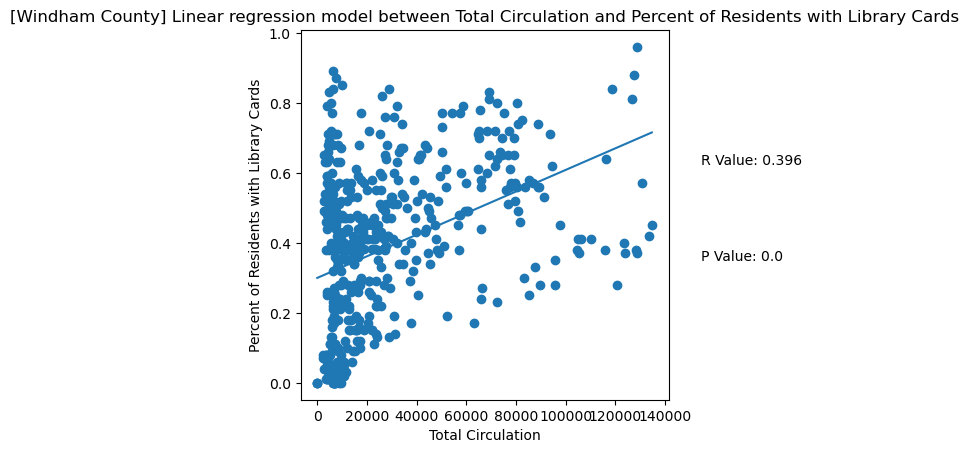

In [51]:
display.Image("[Windham County] Linear regression model between Total Circulation and Percent of Residents with Library Cards.png")

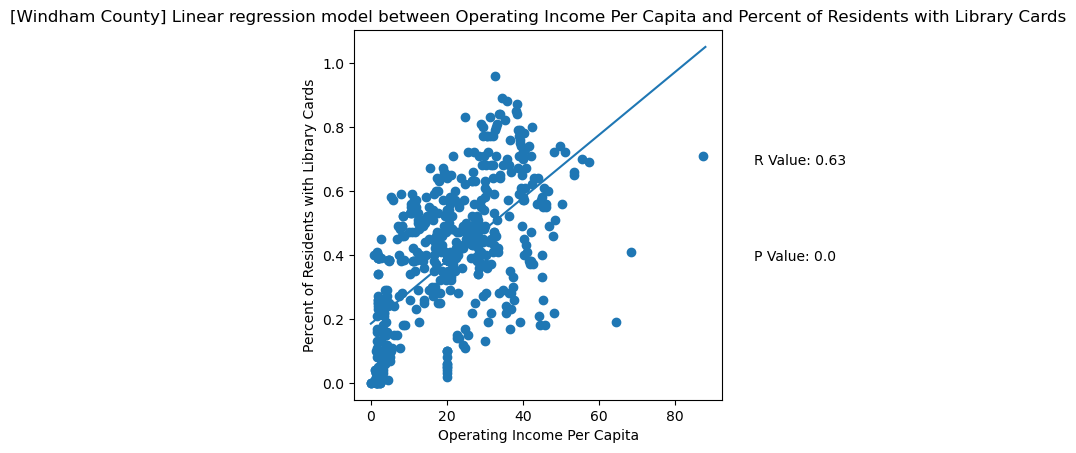

In [53]:
display.Image("[Windham County] Linear regression model between Operating Income Per Capita and Percent of Residents with Library Cards.png")

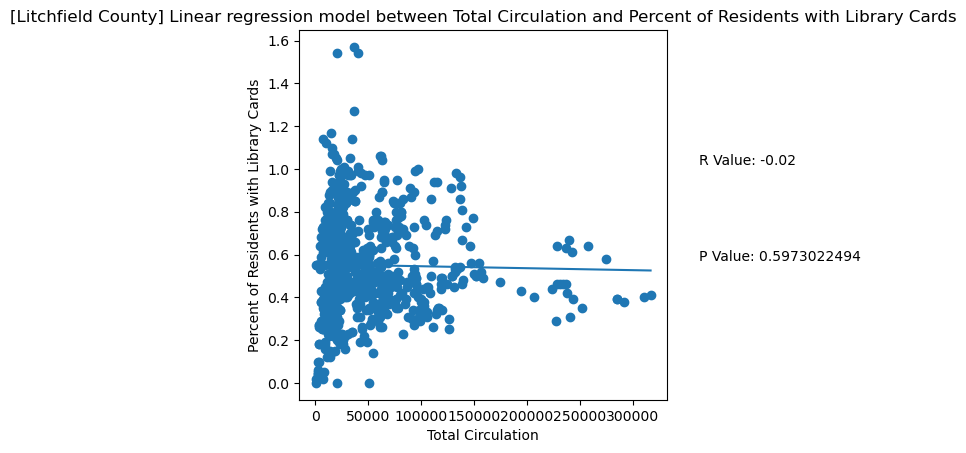

In [55]:
display.Image("[Litchfield County] Linear regression model between Total Circulation and Percent of Residents with Library Cards.png")

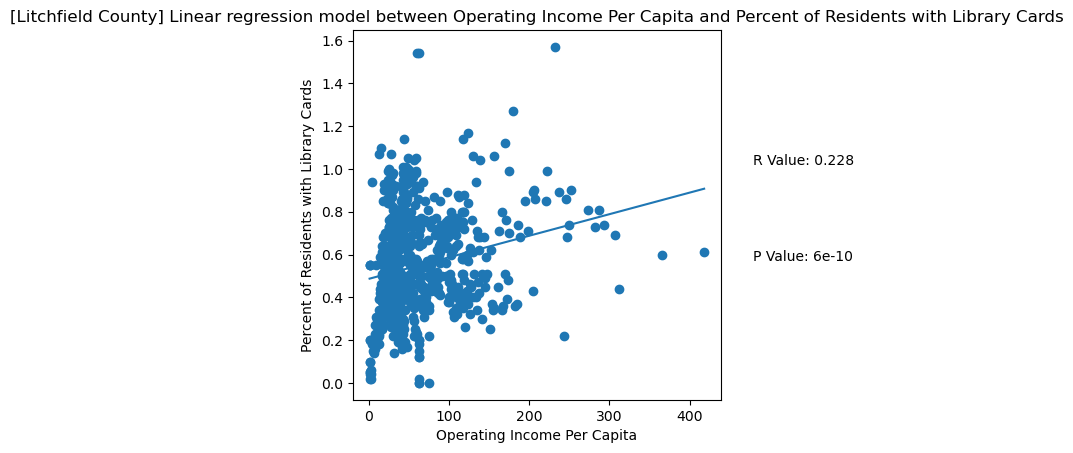

In [57]:
display.Image("[Litchfield County] Linear regression model between Operating Income Per Capita and Percent of Residents with Library Cards.png")

# Violin Plots

#### Allows us to visualize the distribution of our dataset through a combination of kernel density and box plots

- Comparing feature distributions across counties
    - Are there any anomalous features?
        - Skewness: Is the data asymmetrical or lopsided?
        - Outliers: Are there extreme values that significantly different than other points?
        - Multimodality: Are there multiple peaks?

In [32]:
from seaborn import violinplot

In [34]:
features = cld.columns[4:]
countys = cld.County.unique()
libraries = cld.Library.unique()

countyWidg = widgets.Dropdown(
    options=countys,
    description='County:',
    disabled=False,
    style=style
)

libraryWidg = widgets.Dropdown(
    options=libraries,
    description='Library:',
    disabled=False,
)

featureWidg = widgets.Dropdown(
    options=features,
    description='Features:',
    disabled=False,
)

In [36]:
def violinPlot(feature, export=False):
    fig, ax = plt.subplots(figsize = (8,6))
    violinplot(data = cld, x = feature, y="County", alpha = 0.6)
    plt.title(f'Violin Plot of {feature} by County')
    
    if export == True:
        plt.savefig(fname=f"Vioin Plot of {feature} by County", bbox_inches="tight")
    
    plt.show()

In [38]:
interactivePlot2 = interact(violinPlot, feature = featureWidg, export = exportFile)

interactive(children=(Dropdown(description='Features:', options=('AENGLC Rank', 'Population of Service Area', …

# Observations

Going back to the previous analysis comparing Litchfield to Windham, violin plots reveal several interesting features regarding Litchfield County:

* Litchfield has a more uniform and widely variant distribution with regards to *Total Program Attendance & Views Per Capita*.
* Litchfield has the highest median *Collection Served Per Capita*, but their density distribution is also the most uniform and widely variant.

These observations may suggest that Litchfield houses libraries with wildly differing levels of success; determining target metrics for continued library success requires more granular analysis that wouldn't be generalizable to other counties.

In [44]:
def violinPlotCounty(county, feature, library, export=False):
    # Create sub data frame to filter county and library
    subframe = cld[cld['County']==county]
    subframe = cld[cld['Library']==library]
    
    # Violin plotted with chosen feature for the x-axis and library as the y-axid (will dynamically change for each county)
    fig, ax = plt.subplots(figsize = (8, 6))
    violinplot(data = subframe, x = feature, y = 'Library', alpha = 0.5, bw_method = 0.2)
    plt.title(f'Violin Plot of {feature} by {library} for {county} County')
    
    # Allows user to export graph once export button is pressed
    if export == True:
        plt.savefig(fname=f"Vioin Plot of {feature} by County", bbox_inches="tight")
    
    plt.show()

In [46]:
interactivePlot2 = interact(violinPlotCounty, library = libraryWidg, county = countyWidg, feature = featureWidg, export = exportFile)

interactive(children=(Dropdown(description='County:', options=('Tolland', 'New Haven', 'Windham', 'Hartford', …

# References

    Ghilardi, B. (2024, February). Statistical trends in Connecticut public libraries, 2022-2023. https://libguides.ctstatelibrary.org/ld.php?content_id=72332656

    Connecticut State Office of Rural Health. (n.d). CT rural towns. https://www.ruralhealthct.org/towns.htm